In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import time

                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


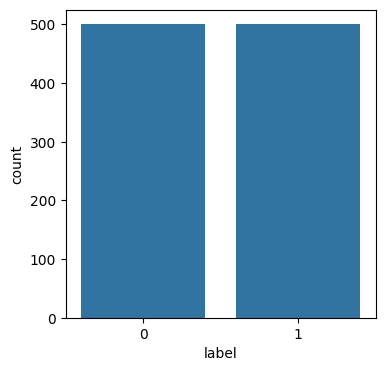

In [2]:
# Load IMDb dataset (test data, 1000 instances)
test_data = pd.read_csv('test_data.csv')
print(test_data.head())

# Test dataset category count plot
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=test_data)
plt.show()

In [5]:
# Pretrained models for sentiment analysis
models = [
    "cardiffnlp/twitter-roberta-base-sentiment",
    "textattack/bert-base-uncased-SST-2",
    "aychang/roberta-base-imdb",
    "t5-small"
]

In [ ]:
# Tokenize and get predictions for each model
results = []

for model_name in models:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    predictions = []
    start_time = time.time()

    for i in range(len(test_data)):
        example = test_data.iloc[i, :]
        inputs = tokenizer(example["text"], return_tensors="pt", max_length=500, truncation=True)
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_class)

    end_time = time.time()
    inference_time = (end_time - start_time) / len(test_data)

    results.append({"model": model_name, "predictions": predictions, "inference_time": inference_time})


In [ ]:
# Evaluate model performance using metrics
metrics_data = []

for result in results:
    model_name = result["model"]
    predicted_labels = result["predictions"]
    inference_time = result["inference_time"]
    true_labels = test_data['label']

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average="weighted")

    metrics_data.append({"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1, "Inference Time": inference_time})


In [ ]:
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

In [ ]:
# Plotting metrics for different models
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=metrics_df, color='skyblue', label='Accuracy')
sns.barplot(x='Model', y='Precision', data=metrics_df, color='salmon', label='Precision')
sns.barplot(x='Model', y='Recall', data=metrics_df, color='lightgreen', label='Recall')
sns.barplot(x='Model', y='F1', data=metrics_df, color='orange', label='F1')

# Adding labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.title('Performance Metrics for Different Models', fontsize=14)
plt.legend()
plt.xticks(rotation=45)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Defining the TOPSIS function
def TOPSIS(df, weights, criteria):
    # Normalize data
    norm_df = df.iloc[:, 1:] / np.sqrt((df.iloc[:, 1:] ** 2).sum())
    weighted_df = norm_df * weights

    # Ideal best and worst
    ideal_best = (criteria * weighted_df).max()
    ideal_worst = (criteria * weighted_df).min()

    # Distances
    distance_best = np.sqrt(((weighted_df - ideal_best) ** 2).sum(axis=1))
    distance_worst = np.sqrt(((weighted_df - ideal_worst) ** 2).sum(axis=1))

    # TOPSIS scores
    scores = distance_worst / (distance_best + distance_worst)
    df["TOPSIS Score"] = scores
    df["TOPSIS Rank"] = df["TOPSIS Score"].rank(ascending=False)
    
    return df.sort_values(by="TOPSIS Rank")

In [ ]:
# Defining weights and criteria
weights = np.array([0.3, 0.3, 0.2, 0.1, 0.1])  # Giving some weight to inference time
criteria = np.array([1, 1, 1, 1, -1])  # Inference time is minimized

# Ranking models using TOPSIS
ranked_df = TOPSIS(metrics_df, weights, criteria)
print(ranked_df)

In [ ]:
# Plotting TOPSIS Scores
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='TOPSIS Score', data=ranked_df, palette="viridis")

plt.xlabel("Model", fontsize=12)
plt.ylabel("TOPSIS Score", fontsize=12)
plt.title("TOPSIS Ranking of Pre-trained Models for Sentiment Analysis", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save plot as an image
plt.savefig("topsis_ranking.png")
plt.show()

# Print final results with explanation
print("\nModel Performance Analysis:")
print(ranked_df)
print("\nAnalysis:")
best_model = ranked_df.iloc[0]['Model']
print(f"The best model according to the TOPSIS ranking is **{best_model}**.")
print("A higher accuracy, precision, recall, and F1-score indicate better predictive performance, while a lower inference time is preferable for real-time applications.")
